## Tonado Prediction Model for the State of Mississippi

## Since 2010 Mississippi has been hit by 693 tornadoes. 

In [49]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import gmaps
import folium as folium
import geopandas as gpd
import os
from folium.plugins import MarkerCluster
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [50]:
#Import and read data from historic data file
miss_hist_data = pd.read_csv('Miss_Tornado_DATA.csv')
miss_hist_data.head()

#turn into dataframe
miss_hist_data_df = pd.DataFrame(miss_hist_data)
miss_hist_data_df.head()

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
0,1950,2,12,2/12/1950,MS,1,0,0,34.60,-89.12,0.00,0.00,2.0,10
1,1950,2,12,2/12/1950,MS,2,2,3,34.60,-89.12,0.00,0.00,0.1,10
2,1950,3,1,3/1/1950,MS,1,0,0,32.50,-88.85,0.00,0.00,0.1,10
3,1950,3,27,3/27/1950,MS,1,2,0,34.73,-88.27,0.00,0.00,0.1,10
4,1950,3,27,3/27/1950,MS,2,0,0,33.13,-89.57,33.25,-89.42,11.9,10


In [51]:
#set up map lat and lon
geometry = gpd.points_from_xy(miss_hist_data_df['slon'], miss_hist_data_df['slat'])
gdf = gpd.GeoDataFrame(miss_hist_data_df, geometry=geometry)


## First Visual to show the data over the map

In [52]:
# Center coordinates of Mississippi
center_lat, center_lon = 32.8, -89.8

# Filter data for the specified date range (2010 - 2021) and magnitude greater than 0
start_date = '1/1/2010'
end_date = '12/13/2021'
filtered_gdf = gdf[(gdf['date'] >= start_date) & (gdf['date'] <= end_date) & (gdf['mag'] > 0)]

# Create a map centered on Mississippi
Mississippi_map = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Define a function to map magnitude values to colors
def get_color(mag):
    colors = {1: 'white', 2: 'blue', 3: 'yellow', 4: 'orange', 5: 'red'}
    return colors.get(int(mag), 'black')

# Add GeoDataFrame to the map
for _, row in filtered_gdf.iterrows():
    popup_text = f"Data Point: {row['mag']} on {row['date']}"  # Customize the popup information as needed
    popup = folium.Popup(popup_text, parse_html=True)
    
    # Get the color for the marker based on magnitude
    marker_color = get_color(row['mag'])
    
    # Create a CircleMarker with the specified color
    folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],  # Latitude first, then longitude
        radius=6,  # Adjust the size of the marker if needed
        popup=popup,
        color='black',
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
    ).add_to(Mississippi_map)

# Display the map
Mississippi_map


## Machine Learning Model to predict Tornadoes in Mississippi

In [53]:
# Load the data
Tornado_data = pd.read_csv("MASTERDATAFILE.csv")
Tornado_data.head()


,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,Tornado,MAGITUDE,Deaths,WINDSPEED
0,1/1/2010,5,-2,0.0,8.7,1,100,6:16:00 PM,7:45:00 AM,6:59:00 AM,...,1027,5,10,340,17,mississippi,NO,0,0,0
1,1/2/2010,2,-3,0.0,8.7,2,85,7:31:00 PM,8:30:00 AM,7:00:00 AM,...,1029,2,10,164,14,mississippi,NO,0,0,0
2,1/3/2010,3,-4,0.0,8.7,2,77,8:42:00 PM,9:09:00 AM,7:00:00 AM,...,1027,3,10,93,12,mississippi,NO,0,0,0
3,1/4/2010,-1,-6,0.0,7.1,1,70,9:51:00 PM,9:44:00 AM,7:00:00 AM,...,1027,-1,10,264,14,mississippi,NO,0,0,0
4,1/5/2010,1,-8,0.0,8.7,2,63,10:57:00 PM,10:15:00 AM,7:00:00 AM,...,1029,1,10,312,13,mississippi,NO,0,0,0


In [54]:
#Display the column names
Tornado_data.columns


Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location',
       'Tornado', 'MAGITUDE', 'Deaths', 'WINDSPEED'],
      dtype='object')

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Preprocess the data
X = Tornado_data[['pressure', 'FeelsLikeC', 'HeatIndexC', 'cloudcover', 'precipMM','humidity',]]
y_tornado = Tornado_data["Tornado"].map({'YES': 1, 'NO': 0}) 

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y_tornado, test_size=0.2, random_state=42)

# Create the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy:", accuracy)


Model Accuracy: 0.96900826446281


In [56]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[936   5]
 [ 25   2]]


In [57]:
#Print the classification report for the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       941
           1       0.29      0.07      0.12        27

    accuracy                           0.97       968
   macro avg       0.63      0.53      0.55       968
weighted avg       0.95      0.97      0.96       968



## The program will be retested using RandomOverSampler module

In [58]:
# Import the RandomOverSampler module form imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# Instantiate the random oversampler model
# # Assign a random_state parameter of 1 to the model
ros = RandomOverSampler(random_state=1)

# Fit the original training data to the random_oversampler model
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [59]:
# Count the distinct values of the resampled labels data
y_resampled.value_counts()

0    3761
1    3761
Name: Tornado, dtype: int64

In [60]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier_2 = LogisticRegression(random_state=1)

# Fit the model using the resampled training data
classifier_2.fit(X_resampled, y_resampled)

# Make a prediction using the testing data
y_pred_2 = classifier_2.predict(X_test)

In [61]:
# Print the balanced_accuracy score of the model
balanced_accuracy_score(y_test, y_pred_2)

0.7758688550399496

In [62]:
# Generate a confusion matrix for the model
confusion_matrix(y_test, y_pred_2)

array([[798, 143],
       [  8,  19]], dtype=int64)

In [63]:
# Print the classification report for the model
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91       941
           1       0.12      0.70      0.20        27

    accuracy                           0.84       968
   macro avg       0.55      0.78      0.56       968
weighted avg       0.97      0.84      0.89       968



## We will predict Deaths against Tornadoes using Linear Regression Model

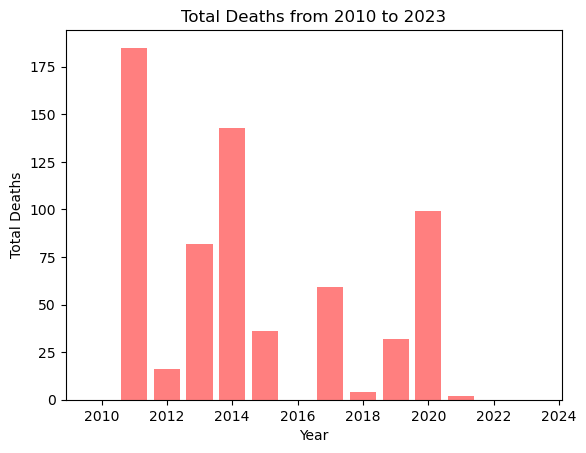

In [64]:
# Convert the "Date" column to pandas datetime format
Tornado_data['date_time'] = pd.to_datetime(Tornado_data['date_time'])

# Filter data for the relevant date range (1/1/2010 to 12/31/2023)
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2023-12-31")
filtered_data = Tornado_data[(Tornado_data['date_time'] >= start_date) & (Tornado_data['date_time'] <= end_date)]

# Group the data by year and calculate the total deaths for each year
deaths_by_year = filtered_data.groupby(filtered_data['date_time'].dt.year)["Deaths"].sum().reset_index()

# Plot the bar chart
plt.bar(deaths_by_year['date_time'], deaths_by_year["Deaths"], color='r', alpha=0.5, align="center")
plt.xlabel("Year")
plt.ylabel("Total Deaths")
plt.title("Total Deaths from 2010 to 2023")
plt.show()



In [65]:
# Preprocess the data and Convert the target labels to binary values
X = Tornado_data[['pressure', 'FeelsLikeC', 'HeatIndexC', 'cloudcover', 'precipMM','humidity',]]
y_tornado_2 = Tornado_data["Tornado"].map({'YES': 1, 'NO': 0}) 
y_deaths = Tornado_data['Deaths']

In [66]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_tornado_2_train, y_tornado_2_test, y_deaths_train, y_deaths_test = train_test_split(X, y_tornado_2, y_deaths, test_size=0.2, random_state=42)


In [67]:
# Create the binary classification model for tornado prediction
model_tornado = LogisticRegression()

# Train the binary classification model for tornado prediction
model_tornado.fit(X_train, y_tornado_2_train)

# Test the binary classification model for tornado prediction
y_pred_tornado = model_tornado.predict(X_test)

# Calculate accuracy for tornado prediction
accuracy_tornado = accuracy_score(y_tornado_2_test, y_pred_tornado)

print("Tornado Model Accuracy:", accuracy_tornado)


Tornado Model Accuracy: 0.96900826446281


In [68]:
# Create the regression model for deaths prediction
model_deaths = LinearRegression()

# Train the regression model for deaths prediction
model_deaths.fit(X_train, y_deaths_train)

# Test the regression model for deaths prediction
y_pred_deaths = model_deaths.predict(X_test)

# Calculate evaluation metrics for deaths prediction
mse_deaths = mean_squared_error(y_deaths_test, y_pred_deaths)
r2_deaths = r2_score(y_deaths_test, y_pred_deaths)

print("Deaths Model:")
print("Mean Squared Error:", mse_deaths)
print("R-squared:", r2_deaths)


Deaths Model:
Mean Squared Error: 16.43745464964118
R-squared: 0.043408304961229716


## The program will be tested against multiple predictions

In [69]:
# Preprocess the data and Convert the target labels to binary values
X = Tornado_data[['pressure', 'FeelsLikeC', 'HeatIndexC', 'cloudcover', 'precipMM','humidity',]]
y = Tornado_data["Tornado"].map({'YES': 1, 'NO': 0}) 
y_magnitude = Tornado_data['MAGITUDE']
y_deaths = Tornado_data['Deaths']
y_windspeed = Tornado_data['WINDSPEED']

In [70]:
# Split the data into 80% training and 20% testing for binary classification (Tornado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into 80% training and 20% testing for regression (Magnitude, Deaths, Windspeed)
X_train_reg, X_test_reg, y_magnitude_train, y_magnitude_test = train_test_split(X, y_magnitude, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_deaths_train, y_deaths_test = train_test_split(X, y_deaths, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_windspeed_train, y_windspeed_test = train_test_split(X, y_windspeed, test_size=0.2, random_state=42)


In [71]:
# Create the binary classification model
model_tornado = LogisticRegression()

# Train the binary classification model
model_tornado.fit(X_train, y_train)

# Test the binary classification model
y_pred_tornado = model_tornado.predict(X_test)

# Calculate accuracy for binary classification (Tornado)
accuracy_tornado = accuracy_score(y_test, y_pred_tornado)

print("Tornado Model Accuracy:", accuracy_tornado)



Tornado Model Accuracy: 0.96900826446281


In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the regression models
model_magnitude = LinearRegression()
model_deaths = LinearRegression()
model_windspeed = LinearRegression()

# Train the regression models
model_magnitude.fit(X_train_reg, y_magnitude_train)
model_deaths.fit(X_train_reg, y_deaths_train)
model_windspeed.fit(X_train_reg, y_windspeed_train)

# Test the regression models
y_pred_magnitude = model_magnitude.predict(X_test_reg)
y_pred_deaths = model_deaths.predict(X_test_reg)
y_pred_windspeed = model_windspeed.predict(X_test_reg)

# Calculate evaluation metrics for regression models (Magnitude, Deaths, Windspeed)
mse_magnitude = mean_squared_error(y_magnitude_test, y_pred_magnitude)
r2_magnitude = r2_score(y_magnitude_test, y_pred_magnitude)

mse_deaths = mean_squared_error(y_deaths_test, y_pred_deaths)
r2_deaths = r2_score(y_deaths_test, y_pred_deaths)

mse_windspeed = mean_squared_error(y_windspeed_test, y_pred_windspeed)
r2_windspeed = r2_score(y_windspeed_test, y_pred_windspeed)

print("Magnitude Model:")
print("Mean Squared Error:", mse_magnitude)
print("R-squared:", r2_magnitude)
print()

print("Deaths Model:")
print("Mean Squared Error:", mse_deaths)
print("R-squared:", r2_deaths)
print()

print("Windspeed Model:")
print("Mean Squared Error:", mse_windspeed)
print("R-squared:", r2_windspeed)


Magnitude Model:
Mean Squared Error: 0.07397441246830609
R-squared: 0.14933238588309283

Deaths Model:
Mean Squared Error: 16.43745464964118
R-squared: 0.043408304961229716

Windspeed Model:
Mean Squared Error: 28731.95236072029
R-squared: 0.08078655435417159


In [73]:
# Train the models
model_magnitude.fit(X_train, y_magnitude_train)
model_deaths.fit(X_train, y_deaths_train)
model_windspeed.fit(X_train, y_windspeed_train)

LinearRegression()

## Making Predictions Using the Random Forest Model

In [74]:
#load and process
X = Tornado_data[["pressure", "FeelsLikeC", "HeatIndexC", "cloudcover", "precipMM", "humidity"]]
y_tornado = Tornado_data["Tornado"].map({"YES": 1, "NO": 0})


In [75]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y_tornado, test_size=0.2, random_state=42)


In [76]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest classifier
model_rf = RandomForestClassifier(random_state=42)

# Train the model on the training data
model_rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [77]:
# Make predictions on the testing data
y_pred = model_rf.predict(X_test)


In [78]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Model Accuracy: 0.9721074380165289
Confusion Matrix:
[[937   4]
 [ 23   4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       941
           1       0.50      0.15      0.23        27

    accuracy                           0.97       968
   macro avg       0.74      0.57      0.61       968
weighted avg       0.96      0.97      0.96       968



In [79]:
# Get the feature importances from the trained model
feature_importance = model_rf.feature_importances_


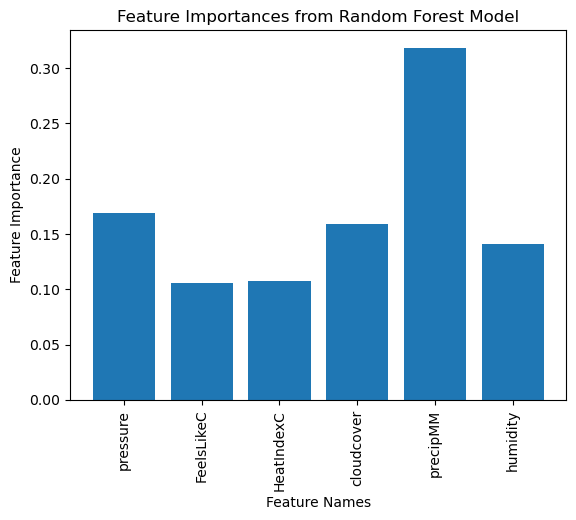

In [80]:
import matplotlib.pyplot as plt

# Get the feature names (column names) from the X dataframe
feature_names = X.columns

# Create a bar chart to visualize the feature importances
plt.bar(feature_names, feature_importance)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importances from Random Forest Model')
plt.xticks(rotation='vertical')
plt.show()
